In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [51]:
import random_light as rl
import readpng as rpng
import tikhonov as tik
import matplotlib.pyplot as plt
import numpy as np
import scipy

In [3]:
img=rpng.get_bwimg("che.png")
Mx,My=np.shape(img)
Mmodel=Mx*My
Ndata=1024
d,W,imgext=rl.create_data_and_designmatrix(img,N=Ndata,p=0.7,width=10)

/home/kawahara/.pyenv/versions/anaconda3-2019.07/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kawahara/.pyenv/versions/anaconda3-2019.07/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Here is the input image (left) and the observed image (right)

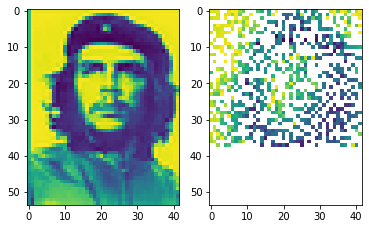

In [4]:
fig=plt.figure()
ax=fig.add_subplot(121)
plt.imshow(img)
ax=fig.add_subplot(122)
plt.imshow(imgext)

Singular Value Decomposition of the design matrix

In [5]:
U,S,VT=np.linalg.svd(W)

Text(0, 0.5, 'Singular value')

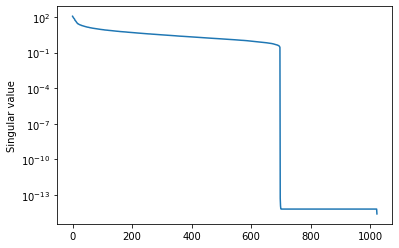

In [6]:
plt.plot(S)
plt.yscale("log")
plt.ylabel("Singular value")

In [7]:
def each_img(i,d):
    return (1.0/S[i])*np.inner(U[:,i],d)*VT[i,:]

In [8]:
cube=[]
for i in range(0,np.min([Ndata,Mmodel])):
    cube.append(each_img(i,d))
cube=np.array(cube)
cumcube=(np.cumsum(cube,axis=0))

In [9]:
from ipywidgets import Play, IntSlider, jslink, HBox, interactive_output
import time
Ndata,Mmodel=np.shape(W)
def f(i):
    fig=plt.figure(figsize=(10,5))
    ax=fig.add_subplot(131)
    plt.plot(S)
    plt.plot(i,S[i],"o",color="red")
    plt.yscale("log")
    plt.ylabel("Singular value")
    ax=fig.add_subplot(132)
    plt.imshow(cube[i].reshape(Mx,My))
    plt.title("Each Image")
    ax=fig.add_subplot(133)
    plt.imshow(cumcube[i].reshape(Mx,My))
    plt.title("Cumulative")
    plt.show()

play = Play(value=0, min=0, max=np.min([Ndata,Mmodel])-1, step=1, interval=150, description="Press play",)
slider = IntSlider(min=0, max=np.min([Ndata,Mmodel])-1)
jslink((play, 'value'), (slider, 'value'))
ui = HBox([play, slider])
out = interactive_output(f, {'i': slider})
display(ui, out)



Output()

## Moore-Penrose Matrix

In [10]:
def MP(d,lim=1.e-13):
    Ndata,Mmodel=np.shape(W)
    plim = np.sum(S>lim)
    Sm=np.zeros(Mmodel)
    for i in range(0,plim):
        Sm=Sm+each_img(i,d)
    return Sm

Text(0.5, 1.0, 'Moore-Penrose Inverse Matrix')

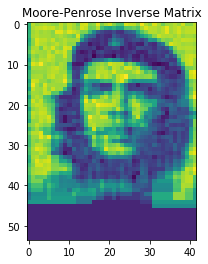

In [11]:
Sm=MP(d)
plt.imshow(Sm.reshape(Mx,My))
plt.title("Moore-Penrose Inverse Matrix")

In [12]:
## noise injection

In [41]:
sigma=0.03
dn = d + np.random.normal(0.0,np.mean(d)*sigma,np.shape(d))

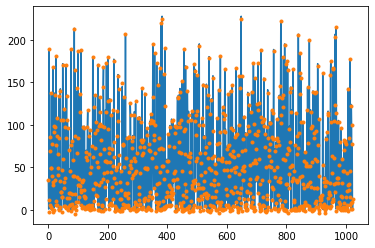

In [42]:
plt.plot(d)
plt.plot(dn,".")

Text(0.5, 1.0, 'Moore-Penrose Inverse Matrix')

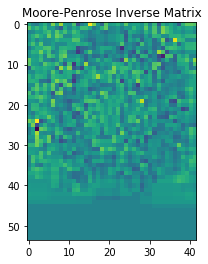

In [43]:
Sm=MP(dn)
plt.imshow(Sm.reshape(Mx,My))
plt.title("Moore-Penrose Inverse Matrix")

Text(0.5, 1.0, 'Moore-Penrose Inverse Matrix')

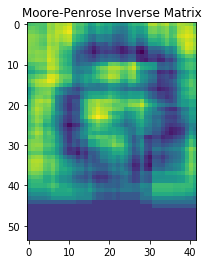

In [44]:
Sm=MP(dn,lim=1.e1)
plt.imshow(Sm.reshape(Mx,My))
plt.title("Moore-Penrose Inverse Matrix")

## Tikhonov Regularization

In [45]:
def Tikh(d,lambdatik):
    p=min(Ndata,Mmodel)
    Sm=np.zeros(Mmodel)
    for i in range(0,p):
        phij=(S[i]/(S[i]**2+lambdatik**2))
        Sm=Sm+phij*np.inner(U[:,i],d)*VT[i,:]
    return Sm

Text(0.5, 1.0, 'Tikhonov')

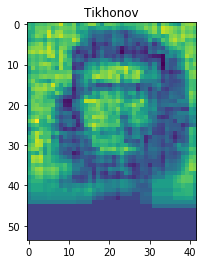

In [46]:
Sm=Tikh(dn,lambdatik=3.0)
plt.imshow(Sm.reshape(Mx,My))
plt.title("Tikhonov")

## Gaussian Process

In [47]:
def Mean_BayesLIP(W,KS,lc,Pid):
    #mean of the posterior given theta and g
    #Pid: data precision matrix (inverse of the data covariance)
    Kw=(W@KS@W.T)
    Nn=np.shape(Kw)[0]
    IKw=np.eye(Nn)+Pid@Kw
    Xlc=scipy.linalg.solve(IKw,Pid@lc,assume_a="pos")
    return KS@W.T@Xlc

In [48]:
gx=((np.array([range(0,Mx)]).T)*np.ones(My))
gy=((np.array([range(0,My)]).T)*np.ones(Mx)).T
gx=gx.flatten()
gy=gy.flatten()
dx = gx - np.array([gx]).T
dy = gy - np.array([gy]).T
sep = np.sqrt(dx*dx + dy*dy)

In [20]:
def RBF(sep,gamma):
    K=np.exp(-(sep)**2/2/(gamma**2))
    return K

In [72]:
def Matern32(sep,gamma):
    fac=np.sqrt(3.0)*np.abs(sep)/gamma
    K=(1.0+fac)*np.exp(-fac)
    return K

In [85]:
gamma=4
alpha=0.001
#KS=alpha*RBF(sep,gamma)
KS=alpha*Matern32(sep,gamma)
Pid=sigma**-2*np.eye(Ndata) #Data precision matrix
mu=Mean_BayesLIP(W,KS,dn,Pid)

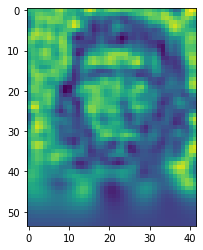

In [87]:
plt.imshow(mu.reshape(Mx,My))

## MCMC